<a href="https://colab.research.google.com/github/arkadev658/Image-identification/blob/main/Ensemble_Learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import torch.utils
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from google.colab import drive

import torchvision.models as models


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [ ]:
data_dir = "/content/drive/MyDrive/ce6051_data/"

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)),transforms.Grayscale(), transforms.ToTensor()])

dataset = ImageFolder(data_dir,transform=transform)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

val_size=50
train_size = len(dataset) -val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(282, 50)

In [ ]:
batch_size=32
train_dl= DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=True)

**VGG16**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8*8*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

**ResNet**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

**GoogLeNet**

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts, k, s, p):
        super(ConvBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts, kernel_size=(k, k), stride=(s, s), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.convolution(input_img)

        return x


class ReduceConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts_1, out_fts_2, k, p):
        super(ReduceConvBlock, self).__init__()
        self.redConv = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts_1, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_fts_1, out_channels=out_fts_2, kernel_size=(k, k), stride=(1, 1), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.redConv(input_img)

        return x


class AuxClassifier(nn.Module):
    def __init__(self, in_fts, num_classes):
        super(AuxClassifier, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(5, 5), stride=(3, 3))
        self.conv = nn.Conv2d(in_channels=in_fts, out_channels=128, kernel_size=(1, 1), stride=(1, 1))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(4 * 4 * 128, 1024)
        self.dropout = nn.Dropout(p=0.7)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.avgpool(input_img)
        x = self.conv(x)
        x = self.relu(x)
        x = x.reshape(N, -1)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.classifier(x)

        return x


class InceptionModule(nn.Module):
    def __init__(self, curr_in_fts, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool_proj):
        super(InceptionModule, self).__init__()
        self.conv1 = ConvBlock(curr_in_fts, f_1x1, 1, 1, 0)
        self.conv2 = ReduceConvBlock(curr_in_fts, f_3x3_r, f_3x3, 3, 1)
        self.conv3 = ReduceConvBlock(curr_in_fts, f_5x5_r, f_5x5, 5, 2)

        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=curr_in_fts, out_channels=f_pool_proj, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )

    def forward(self, input_img):
        out1 = self.conv1(input_img)
        out2 = self.conv2(input_img)
        out3 = self.conv3(input_img)
        out4 = self.pool_proj(input_img)

        x = torch.cat([out1, out2, out3, out4], dim=1)

        return x


class MyGoogleNet(nn.Module):
    def __init__(self, in_fts=1, num_class=2):
        super(MyGoogleNet, self).__init__()
        self.conv1 = ConvBlock(in_fts, 64, 7, 2, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, 1, 1, 0),
            ConvBlock(64, 192, 3, 1, 1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.aux_classifier1 = AuxClassifier(512, num_class)
        self.aux_classifier2 = AuxClassifier(528, num_class)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1024 * 7 * 7, num_class)
        )

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.conv1(input_img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool1(x)
        x = self.inception_4a(x)
        out1 = self.aux_classifier1(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        out2 = self.aux_classifier2(x)
        x = self.inception_4e(x)
        x = self.maxpool1(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.avgpool(x)
        x = x.reshape(N, -1)
        x = self.classifier(x)
        if self.training == True:
            return [x, out1, out2]
        else:
            return x

In [ ]:

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

**Training cell with Ensemble Learning**

The loss calculated from all the models are added and then the parameters from all the models are trained with respect to the total loss.

In [ ]:

def fit(epochs, lr, model1,model2,model3, train_loader, val_loader,config):
    parameters = list(model1.parameters())+list(model2.parameters())+list(model3.parameters())
    optimizer = torch.optim.Adam(parameters,lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    discount = 0.3
    for epoch in range(epochs):
        train_losses = []
        model1.train()
        model2.train()
        model3.train()
        for batch in train_loader:

            images, labels = batch

            # Calculating loss for GoogLeNet
            out1,out2,out3 = model2(images)
            gl_loss = loss_fn(out1,labels)+discount*(loss_fn(out2,labels))+loss_fn(out3,labels)
            
            # Calculating loss for VGG16
            vgg_out = model1(images)
            vgg_loss=loss_fn(vgg_out,labels)

            # Calculating loss for ResNet
            resnet_out=model3(images)
            res_loss=loss_fn(resnet_out,labels)

            total_loss = gl_loss + vgg_loss + res_loss #total loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            train_losses.append(total_loss.item())
        
        # Validation phase
        model1.eval()
        model2.eval()
        model3.eval()
        length=0
        accuracy=0
        with torch.no_grad():
          for batch in val_loader:
            images,labels= batch
            length+=labels.shape[0]
            vgg_out=model1(images)
            gl_out=model2(images)
            resnet_out=model3(images)
            final_out=vgg_out+gl_out+resnet_out
            predictions=torch.argmax(final_out,dim=1)
            accuracy+=torch.sum(predictions==labels).item()
          accuracy=accuracy/length
          print(f'Epoch: {epoch}, training loss: {sum(train_losses)}, validation accuracy: {accuracy}')

        # Storing the parameters that has max accuracy
        max_acc=0
        if accuracy>max_acc:
          max_acc=accuracy
          weights={'resnet':model3.state_dict(), 'vgg': model1.state_dict(), 'gl': model2.state_dict()}
          torch.save(weights,f'/content/drive/MyDrive/Model_weights/weights_{config}.pth')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

vgg=VGG16()
resnet= ResNet(ResidualBlock,[3, 4, 6, 3])
googlenet= MyGoogleNet()
to_device(vgg, device)
to_device(resnet, device)
to_device(googlenet, device)

fit(epochs=500,lr=5e-4,model1=vgg,model2=googlenet,model3=resnet,train_loader=train_dl, val_loader= val_dl,config='5e-4')

Epoch: 0, training loss: 107.25188899040222, validation accuracy: 0.76
Epoch: 1, training loss: 25.833942413330078, validation accuracy: 0.24
Epoch: 2, training loss: 22.56048607826233, validation accuracy: 0.76
Epoch: 3, training loss: 21.88282561302185, validation accuracy: 0.78
Epoch: 4, training loss: 21.613712787628174, validation accuracy: 0.76
Epoch: 5, training loss: 21.299620389938354, validation accuracy: 0.8
Epoch: 6, training loss: 21.631102323532104, validation accuracy: 0.62
Epoch: 7, training loss: 21.398778796195984, validation accuracy: 0.74
Epoch: 8, training loss: 19.126831889152527, validation accuracy: 0.76
Epoch: 9, training loss: 19.691773176193237, validation accuracy: 0.8
Epoch: 10, training loss: 19.911997318267822, validation accuracy: 0.7
Epoch: 11, training loss: 20.29102349281311, validation accuracy: 0.78
Epoch: 12, training loss: 20.052700996398926, validation accuracy: 0.76
Epoch: 13, training loss: 19.706494688987732, validation accuracy: 0.74
Epoch: 1

**Max Accuracy = 98%**

Results array contains the loss and validation accuracy for each epoch.

In [ ]:
results= np.array([[107.25188899040222, 0.76] ,
[25.833942413330078, 0.24],
[22.56048607826233,  0.76],
[21.88282561302185,  0.78],
[21.613712787628174, 0.76],
[21.299620389938354, 0.8],
[21.631102323532104, 0.62],
[21.398778796195984, 0.74],
[19.126831889152527, 0.76],
[19.691773176193237, 0.8],
[19.911997318267822, 0.7],
[20.29102349281311,  0.78],
[20.052700996398926, 0.76],
[19.706494688987732, 0.74],
[19.27975821495056,  0.76],
[19.450725555419922, 0.86],
[18.19158184528351,  0.8],
[17.941537737846375, 0.78],
[18.584592580795288, 0.76],
[18.1101713180542,   0.82],
[17.78078818321228,  0.82],
[18.34680998325348,  0.84],
[18.036007523536682, 0.84],
[17.629372119903564, 0.82],
[17.334295511245728, 0.78],
[17.243548274040222, 0.86],
[17.318265438079834, 0.88],
[20.5971257686615,   0.64],
[18.120219469070435, 0.8],
[17.971214294433594, 0.82],
[17.67947244644165,  0.74],
[16.957242250442505, 0.9],
[17.102784156799316, 0.88],
[16.355698585510254, 0.7],
[15.905005693435669, 0.92],
[17.091970562934875, 0.88],
[16.252914667129517, 0.92],
[15.711724042892456, 0.9],
[15.79221510887146,  0.82],
[17.611580848693848, 0.86],
[16.126421213150024, 0.92],
[15.00182855129242,  0.82],
[15.941124320030212, 0.64],
[15.627903938293457, 0.92],
[43.994540214538574, 0.84],
[17.973727107048035, 0.84],
[17.417788982391357, 0.66],
[16.420853972434998, 0.9],
[16.354183554649353, 0.9],
[15.287301659584045, 0.9],
[15.273971319198608, 0.88],
[15.233887076377869, 0.94],
[15.408331036567688, 0.84],
[15.234239339828491, 0.86],
[14.835208535194397, 0.92],
[14.612184882164001, 0.94],
[14.838491082191467, 0.9],
[15.439788699150085, 0.9],
[15.601767420768738, 0.62],
[14.351719975471497, 0.84],
[33.89645159244537,  0.68],
[15.355485558509827, 0.94],
[14.725680589675903, 0.94],
[15.569645166397095, 0.86],
[14.786845564842224, 0.92],
[405.59743905067444, 0.94],
[16.163108348846436, 0.94],
[14.206981897354126, 0.94],
[15.340217590332031, 0.94],
[14.645265936851501, 0.94],
[14.87218689918518,  0.92],
[14.828238844871521, 0.94],
[15.06484580039978,  0.76],
[15.567708134651184, 0.92],
[14.729777574539185, 0.9],
[14.34645164012909,  0.96],
[13.524823069572449, 0.94],
[13.473055720329285, 0.92],
[14.905906677246094, 0.9],
[15.862257361412048, 0.84],
[14.13014042377472,  0.86],
[13.778248906135559, 0.92],
[13.743549346923828, 0.92],
[13.467058300971985, 0.92],
[13.211821675300598, 0.96],
[13.719985127449036, 0.92],
[19.344313979148865, 0.94],
[13.443794965744019, 0.98],
[13.128816485404968, 0.9],
[12.872384428977966, 0.92],
[12.969258069992065, 0.96],
[13.608688354492188, 0.92],
[16.325796127319336, 0.72],
[15.42717444896698,  0.44],
[14.256540536880493, 0.8],
[14.05215334892273,  0.86],
[13.718313217163086, 0.96],
[13.07339096069336,  0.9],
[13.969943404197693, 0.94],
[13.931420803070068, 0.9],
[225.84381365776062, 0.86],
[20.920639753341675, 0.88],
[14.891143560409546, 0.88],
[14.599742770195007, 0.94],
[13.7251718044281,   0.94],
[13.656996607780457, 0.94],
[13.23764157295227,  0.98],
[13.510172605514526, 0.96],
[13.526621222496033, 0.92],
[13.575941562652588, 0.94],
[13.38430380821228,  0.94],
[13.895440697669983, 0.92],
[13.18288516998291,  0.94],
[12.84907054901123,  0.94],
[12.92620837688446,  0.94],
[13.44042980670929,  0.9],
[26.331040859222412, 0.94],
[13.810225129127502, 0.96],
[13.238296627998352, 0.94],
[13.265559077262878, 0.94],
[13.703726768493652, 0.82],
[13.830843329429626, 0.84],
[14.098848819732666, 0.94],
[13.721737265586853, 0.9],
[13.360353231430054, 0.9],
[13.112668991088867, 0.88],
[13.148190379142761, 0.96],
[13.04345965385437,  0.9],
[14.608285784721375, 0.94],
[13.705368995666504, 0.88],
[13.272045135498047, 0.92],
[14.542697072029114, 0.92],
[13.038252234458923, 0.96],
[13.091106176376343, 0.96],
[13.244120478630066, 0.96],
[13.213231325149536, 0.96],
[13.005736470222473, 0.94],
[12.770219802856445, 0.92],
[12.734620332717896, 0.92],
[12.643303751945496, 0.9],
[12.58078157901764,  0.94],
[13.280941605567932, 0.94],
[13.182220816612244, 0.98],
[12.306514859199524, 0.96],
[12.204280138015747, 0.96],
[12.655524134635925, 0.94],
[12.314379572868347, 0.94],
[12.636716604232788, 0.94],
[12.375135779380798, 0.94],
[12.114420890808105, 0.94],
[12.080228924751282, 0.94],
[11.935133457183838, 0.94],
[12.03395402431488,  0.96],
[11.977018356323242, 0.96],
[12.0255725979805,   0.94],
[12.04240608215332,  0.94],
[12.755001783370972, 0.94],
[13.065986514091492, 0.46],
[16.79375696182251,  0.9],
[13.64854097366333,  0.9],
[14.087549328804016, 0.96],
[12.429959177970886, 0.94],
[12.264193177223206, 0.96],
[12.022680699825287, 0.9],
[12.228041648864746, 0.92],
[12.972240805625916, 0.98],
[13.539010643959045, 0.9],
[12.763541102409363, 0.98],
[13.087638258934021, 0.96],
[13.291111588478088, 0.96],
[12.68020474910736,  0.96],
[13.583034038543701, 0.98],
[12.448493361473083, 0.92],
[14.332367181777954, 0.86],
[12.872892379760742, 0.92],
[12.756957292556763, 0.82],
[11.848612904548645, 0.96],
[12.188432455062866, 0.96],
[12.272928833961487, 0.98],
[12.94887375831604,  0.92],
[12.510391116142273, 0.98],
[12.312790751457214, 0.96],
[12.91334617137909,  0.96],
[13.863521456718445, 0.96],
[12.33329951763153,  0.98],
[11.791438937187195, 0.98],
[11.612900733947754, 0.98],
[11.390188336372375, 0.96],
[11.32925295829773,  0.96],
[11.452096700668335, 0.94],
[11.209587097167969, 0.94],
[11.246356189250946, 0.96],
[11.438064813613892, 0.96],
[11.423580527305603, 0.96],
[12.784647464752197, 0.94],
[11.344922244548798, 0.62],
[12.424326658248901, 0.94],
[12.25683218240738,  0.98],
[11.596610307693481, 0.96],
[11.56476080417633,  0.96],
[11.45610374212265,  0.96],
[11.185682713985443, 0.96],
[11.16374808549881,  0.96],
[11.841139197349548, 0.96],
[11.719849348068237, 0.94],
[11.634280443191528, 0.94],
[11.420774638652802, 0.94],
[11.88833212852478,  0.96],
[11.546605587005615, 0.96],
[17.974971771240234, 0.84],
[16.982444763183594, 0.94],
[12.60483431816101,  0.92],
[14.440301775932312, 0.72],
[13.16894519329071,  0.92],
[12.919196128845215, 0.94],
[12.978396892547607, 0.94],
[11.603451490402222, 0.96],
[12.21460247039795,  0.96],
[11.664886772632599, 0.94],
[11.199709296226501, 0.94],
[11.185473918914795, 0.96],
[10.86640453338623,  0.98],
[10.969503223896027, 0.96],
[11.109736204147339, 0.96],
[10.992727160453796, 0.94],
[10.942774593830109, 0.96],
[11.191819489002228, 0.96],
[11.434893012046814, 0.94],
[11.197623312473297, 0.94],
[10.647314190864563, 0.96],
[10.836863577365875, 0.94],
[10.963306546211243, 0.96],
[11.133396863937378, 0.96],
[11.00818806886673,  0.96],
[10.499836444854736, 0.96],
[10.649625837802887, 0.98],
[10.629753470420837, 0.98],
[11.678726434707642, 0.94],
[11.01844173669815,  0.94],
[10.963666558265686, 0.9],
[10.98892331123352,  0.78],
[12.570443451404572, 0.86],
[12.941751480102539, 0.9],
[11.615530729293823, 0.92],
[11.859075009822845, 0.96],
[11.518455922603607, 0.92],
[11.22091007232666,  0.92],
[11.265336513519287, 0.96],
[10.559140026569366, 0.92],
[10.743849039077759, 0.92],
[10.826182305812836, 0.92],
[10.892179012298584, 0.96],
[10.333155035972595, 0.94],
[11.114894449710846, 0.94],
[10.030623018741608, 0.94],
[10.982457280158997, 0.92],
[10.535089433193207, 0.92],
[11.03674852848053,  0.92],
[10.414485454559326, 0.92],
[10.946669042110443, 0.92],
[11.299031674861908, 0.92],
[11.047506630420685, 0.94],
[10.525942921638489, 0.96],
[11.477888822555542, 0.94],
[11.289289951324463, 0.94],
[10.884993731975555, 0.96],
[11.774136781692505, 0.94],
[10.994468629360199, 0.88],
[10.481562316417694, 0.84],
[10.339106857776642, 0.94],
[10.085973262786865, 0.94],
[10.321798324584961, 0.94],
[10.247230052947998, 0.94],
[10.107139468193054, 0.96],
[9.91774731874466,   0.98],
[9.739322185516357,  0.96],
[10.00330114364624,  0.96],
[9.85121738910675,   0.94],
[9.845596849918365,  0.94],
[9.899272680282593,  0.94],
[10.510012567043304, 0.94],
[10.959344148635864, 0.92],
[10.247629225254059, 0.92],
[10.503147661685944, 0.94],
[10.359900712966919, 0.94],
[9.829397857189178,  0.94],
[9.60593068599701,   0.94],
[9.318403661251068,  0.94],
[9.375420987606049,  0.94],
[9.16522741317749,   0.94],
[14.128775537014008, 0.9],
[15.503673076629639, 0.94],
[12.651037216186523, 0.9],
[106.90310591459274, 0.94],
[11.918389320373535, 0.9],
[12.856079161167145, 0.94],
[11.365121603012085, 0.94],
[11.241119742393494, 0.94],
[10.852195918560028, 0.94],
[9.802440226078033,  0.94],
[9.778061509132385,  0.94],
[9.517381370067596,  0.92],
[9.860189259052277,  0.94],
[9.085079848766327,  0.94],
[9.369650661945343,  0.94],
[8.930795311927795,  0.94],
[9.803430378437042,  0.94],
[11.823101103305817, 0.94],
[9.883679330348969,  0.92],
[9.40126621723175,   0.94],
[8.99704909324646,   0.94],
[9.148062348365784,  0.94],
[9.035866677761078,  0.92],
[8.751290440559387,  0.92],
[8.742142081260681,  0.92],
[8.582392930984497,  0.92],
[8.452473282814026,  0.92],
[8.49326777458191,   0.92],
[8.551158905029297,  0.92],
[9.444063246250153,  0.92],
[8.518337905406952,  0.92],
[8.378936111927032,  0.92],
[8.261101722717285,  0.92],
[8.174911797046661,  0.92],
[8.066434621810913,  0.92],
[8.472422301769257,  0.92],
[7.953077018260956,  0.92],
[7.667237818241119,  0.92],
[7.916292905807495,  0.92],
[7.696897268295288,  0.92],
[7.763690173625946,  0.92],
[7.45940563082695,   0.92],
[7.54222559928894,   0.92],
[7.463537514209747,  0.92],
[8.083580493927002,  0.92],
[9.77597051858902,   0.9],
[9.752771198749542,  0.94],
[8.283731043338776,  0.94],
[8.77200335264206,   0.94],
[7.943544626235962,  0.94],
[7.359462797641754,  0.96],
[7.911778509616852,  0.94],
[8.381574809551239,  0.94],
[8.334562957286835,  0.94],
[8.180866837501526,  0.94],
[9.651939243078232,  0.92],
[9.575839459896088,  0.94],
[8.388961970806122,  0.94],
[7.55546772480011,   0.94],
[7.731921702623367,  0.94],
[7.165502607822418,  0.94],
[7.055198550224304,  0.94],
[7.2450063824653625, 0.94],
[7.588439464569092,  0.92],
[6.957212150096893,  0.92],
[6.781172186136246,  0.94],
[6.515010386705399,  0.94],
[6.591641843318939,  0.94],
[6.554719507694244,  0.94],
[7.006340354681015,  0.96],
[7.149480760097504,  0.94],
[6.622666239738464,  0.94],
[7.4152843952178955, 0.92],
[6.573410630226135,  0.94],
[6.59071284532547,   0.94],
[7.603594541549683,  0.94],
[6.207359969615936,  0.94],
[6.280250132083893,  0.94],
[6.269041657447815,  0.96],
[6.127597987651825,  0.94],
[6.13063457608223,   0.94],
[6.411412686109543,  0.94],
[6.581619501113892,  0.96],
[6.663586497306824,  0.96],
[6.630145728588104,  0.94],
[6.459609508514404,  0.96],
[6.57111918926239,   0.96],
[6.654913783073425,  0.94],
[6.276745080947876,  0.94],
[6.149360835552216,  0.94],
[6.279200315475464,  0.94],
[6.142214685678482,  0.94],
[6.672152578830719,  0.94],
[6.514679491519928,  0.94],
[6.041624486446381,  0.94],
[6.455175429582596,  0.94],
[6.380042612552643,  0.94],
[6.110017478466034,  0.94],
[5.700228929519653,  0.92],
[6.162489116191864,  0.9],
[6.59134441614151,   0.92],
[6.142315655946732,  0.92],
[7.173696786165237,  0.9],
[6.442378640174866,  0.92],
[5.965920239686966,  0.94],
[5.9810077250003815, 0.94],
[6.033191561698914,  0.94],
[6.9748497903347015, 0.92],
[5.684953570365906,  0.9],
[6.095718264579773,  0.86],
[5.944151163101196,  0.92],
[6.367250889539719,  0.92],
[6.817752480506897,  0.94],
[6.693067103624344,  0.94],
[7.006066828966141,  0.94],
[6.19697043299675,   0.94],
[6.312712490558624,  0.94],
[5.735510468482971,  0.92],
[6.4297089874744415, 0.92],
[5.6977419257164,    0.92],
[5.906999737024307,  0.92],
[5.986186355352402,  0.92],
[5.507796555757523,  0.94],
[5.282027631998062,  0.94],
[5.753494024276733,  0.94],
[5.223672986030579,  0.94],
[6.448237627744675,  0.94],
[6.130524069070816,  0.9],
[5.618257462978363,  0.92],
[6.927860856056213,  0.92],
[8.2778842151165,    0.9],
[7.069311738014221,  0.92],
[6.930433362722397,  0.92],
[6.288222283124924,  0.92],
[5.567834168672562,  0.94],
[5.742398291826248,  0.94],
[5.434420049190521,  0.94],
[6.025317192077637,  0.94],
[5.561864793300629,  0.92],
[5.373705446720123,  0.96],
[5.366817802190781,  0.94],
[5.2656406462192535, 0.94],
[5.096636801958084,  0.9],
[5.868762135505676,  0.94],
[6.098162829875946,  0.92],
[5.617604315280914,  0.92],
[5.682876288890839,  0.88],
[5.699741959571838,  0.88],
[7.427728056907654,  0.92],
[5.52137491106987,   0.9],
[5.441090643405914,  0.94],
[5.046865791082382,  0.94],
[5.3119432628154755, 0.94],
[5.279879003763199,  0.92],
[365.8181833922863,  0.94],
[12.490917801856995, 0.94],
[9.968367516994476,  0.94],
[9.52358764410019,   0.9],
[9.7772336602211,    0.92],
[8.559982419013977,  0.92],
[9.023702621459961,  0.94],
[8.839198589324951,  0.86],
[8.539810955524445,  0.92],
[12.27503627538681,  0.84],
[9.758770108222961,  0.86],
[11.629106760025024, 0.84],
[8.91147893667221,   0.94],
[8.493490755558014,  0.9],
[7.815130174160004,  0.94],
[7.554347097873688,  0.9],
[7.025207877159119,  0.92],
[6.751644790172577,  0.94],
[6.468867480754852,  0.94],
[6.717322379350662,  0.92],
[7.262353956699371,  0.94],
[6.392585575580597,  0.94],
[5.666856378316879,  0.94],
[5.913358390331268,  0.94],
[5.408264845609665,  0.92],
[5.771631628274918,  0.94],
[5.646660685539246,  0.94],
[5.28668737411499,   0.92],
[5.362581372261047,  0.92],
[5.37738773226738,   0.94],
[5.674441605806351,  0.94],
[7.057980418205261,  0.94],
[7.532341122627258,  0.94],
[6.457746773958206,  0.96],
[5.442401051521301,  0.96],
[5.761453747749329,  0.92],
[5.558156579732895,  0.94],
[5.256218820810318,  0.94],
[5.237007737159729,  0.94],
[5.173799306154251,  0.94],
[5.222763776779175,  0.92],
[5.186945885419846,  0.92],
[5.150168985128403,  0.92],
[5.3245729804039,    0.94],
[5.546350717544556,  0.96],
[88.50883921980858,  0.94],
[23.383190870285034, 0.94],
[12.541474640369415, 0.92],
[11.826293468475342, 0.84],
[11.671406745910645, 0.94],
[11.283230125904083, 0.92],
[11.969717979431152, 0.94],
[11.101055264472961, 0.94],
[10.436922252178192, 0.94],
[10.43502277135849,  0.94],
[10.284641683101654, 0.94]])

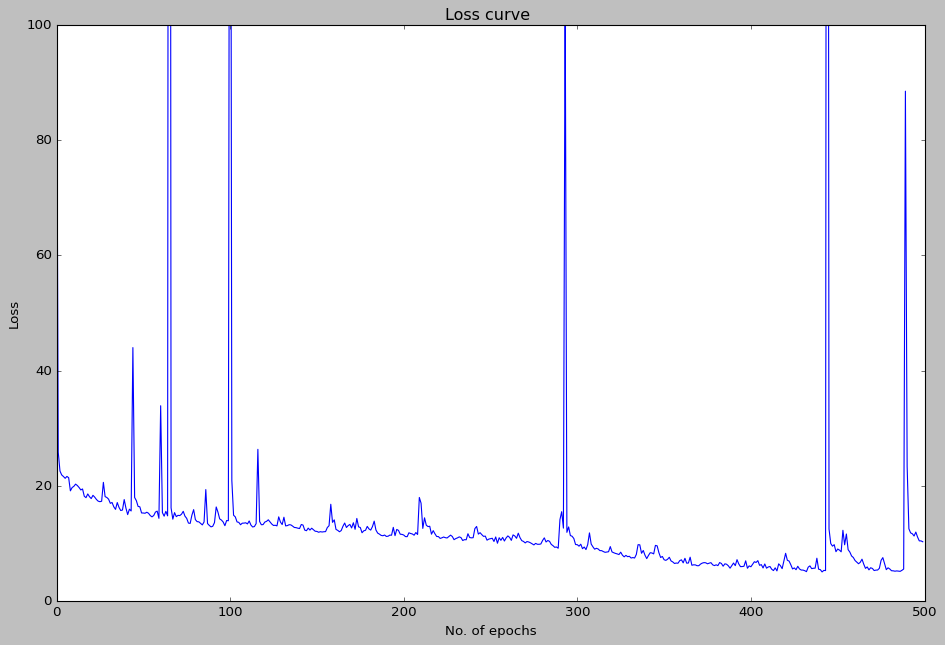

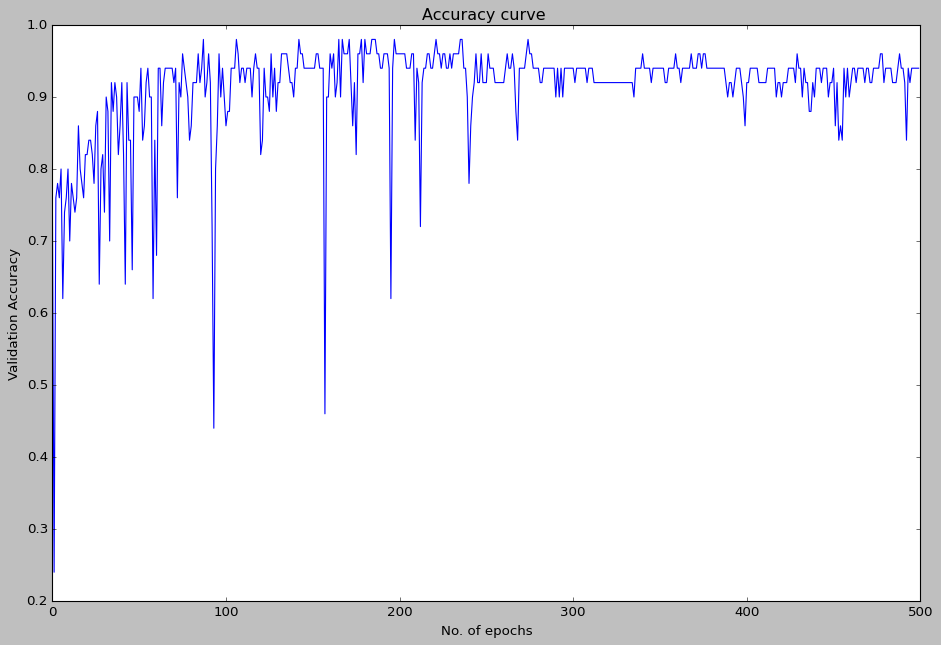

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.ylim(0,100)
plt.plot(np.arange(len(results)),results[:,0])
plt.title('Loss curve ')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(results)),results[:,1])
plt.title('Accuracy curve ')
plt.xlabel('No. of epochs')
plt.ylabel('Validation Accuracy')
plt.show()